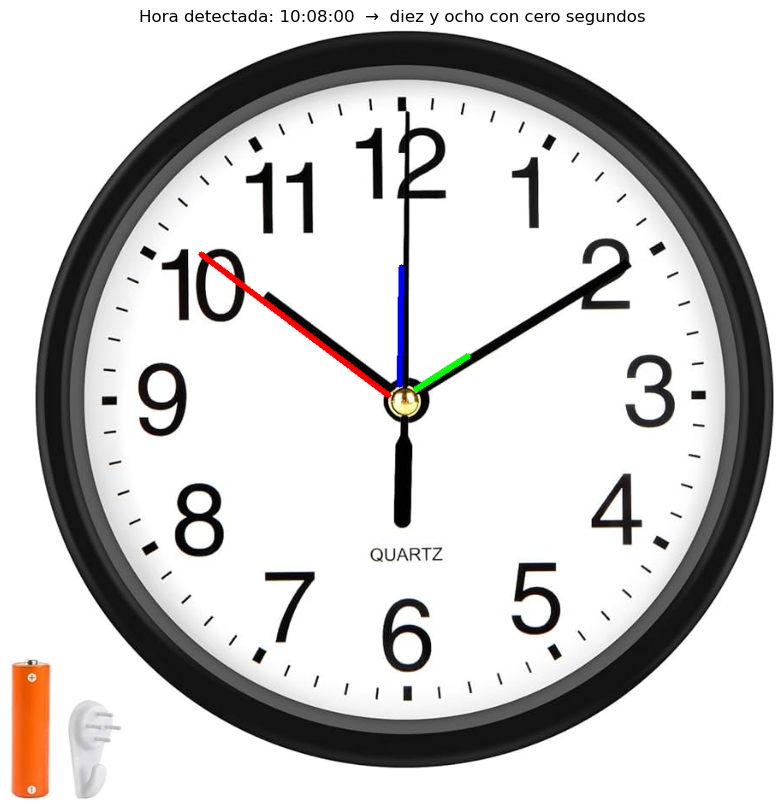

In [56]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

imagen_bgr = cv2.imread('reloj5.jpg')
imagen_rgb = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2RGB)

gris = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2GRAY)
gris = cv2.GaussianBlur(gris, (5, 5), 1)
gris = cv2.equalizeHist(gris)

bordes = cv2.Canny(gris, 50, 150)

lineas = cv2.HoughLinesP(bordes, 1, np.pi/180, threshold=80, minLineLength=50, maxLineGap=20)

centro_x = imagen_bgr.shape[1] // 2
centro_y = imagen_bgr.shape[0] // 2

def calcular_angulo(x1, y1, x2, y2):
    dist1 = np.hypot(x1 - centro_x, y1 - centro_y)
    dist2 = np.hypot(x2 - centro_x, y2 - centro_y)
    if dist1 > dist2:
        dx = x1 - centro_x
        dy = centro_y - y1
    else:
        dx = x2 - centro_x
        dy = centro_y - y2
    angulo = np.degrees(np.arctan2(dy, dx))
    angulo = (90 - angulo) % 360
    return angulo

manecillas = []
if lineas is not None:
    for linea in lineas:
        x1, y1, x2, y2 = linea[0]
        longitud = np.hypot(x2 - x1, y2 - y1)
        distancia_centro = min(np.hypot(x1 - centro_x, y1 - centro_y), np.hypot(x2 - centro_x, y2 - centro_y))
        if distancia_centro < 100 and 40 < longitud < 300:
            angulo = calcular_angulo(x1, y1, x2, y2)
            manecillas.append({
                'puntos': (x1, y1, x2, y2),
                'longitud': longitud,
                'angulo': angulo
            })

def buscar_manecilla_cercana(a_esperado, usadas):
    min_diff = 360
    mejor = None
    for m in manecillas:
        if m in usadas:
            continue
        diff = abs((m['angulo'] - a_esperado + 180) % 360 - 180)
        if diff < min_diff:
            min_diff = diff
            mejor = m
    return mejor

def numero_a_texto(n):
    unidades = ["cero", "uno", "dos", "tres", "cuatro", "cinco", "seis", "siete", "ocho", "nueve"]
    especiales = {10:"diez",11:"once",12:"doce",13:"trece",14:"catorce",15:"quince",16:"dieciséis",17:"diecisiete",18:"dieciocho",19:"diecinueve"}
    decenas = ["", "", "veinte", "treinta", "cuarenta", "cincuenta"]

    if 0 <= n < 10:
        return unidades[n]
    elif 10 <= n < 20:
        return especiales[n]
    elif 20 <= n < 60:
        d = n // 10
        u = n % 10
        if u == 0:
            return decenas[d]
        else:
            return decenas[d] + " y " + unidades[u]
    else:
        return str(n)  

if len(manecillas) >= 3:
    usadas = []
    horario = buscar_manecilla_cercana(250, usadas)  
    usadas.append(horario)
    minutero = buscar_manecilla_cercana(30, usadas)   
    usadas.append(minutero)
    segundero = buscar_manecilla_cercana(0, usadas) 
    usadas.append(segundero)

    hora = int((horario['angulo'] / 30) % 12)
    if hora == 0:
        hora = 12  
    minutos = int((minutero['angulo'] / 6) % 60)
    segundos = int((segundero['angulo'] / 6) % 60)

    texto_hora = numero_a_texto(hora)
    texto_minutos = numero_a_texto(minutos)
    texto_segundos = numero_a_texto(segundos)

    texto_literal = f"{texto_hora} y {texto_minutos} con {texto_segundos} segundo{'s' if segundos != 1 else ''}"

    imagen_resultado = imagen_rgb.copy()
    cv2.line(imagen_resultado, (horario['puntos'][0], horario['puntos'][1]),(horario['puntos'][2], horario['puntos'][3]), (255, 0, 0), 5)  # Hora - rojo
    cv2.line(imagen_resultado, (minutero['puntos'][0], minutero['puntos'][1]),(minutero['puntos'][2], minutero['puntos'][3]), (0, 255, 0), 5)  # Minuto - verde
    cv2.line(imagen_resultado, (segundero['puntos'][0], segundero['puntos'][1]),(segundero['puntos'][2], segundero['puntos'][3]), (0, 0, 255), 5)  # Segundo - azul

    plt.figure(figsize=(10, 10))
    plt.imshow(imagen_resultado)
    plt.title(f'Hora detectada: {hora:02d}:{minutos:02d}:{segundos:02d}  →  {texto_literal}')
    plt.axis('off')
    plt.show()
else:
    print("No se detectaron suficientes manecillas.")

